In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

In [47]:
# Set plot style
sns.set_theme(style="whitegrid")

# Farms

## Exploratory Data Analysis

In [48]:
# Load farm dataset
farms_df = pd.read_excel("../../data/farms.xlsx")

In [49]:
# Display the first few rows
print("First 5 rows:")
print(farms_df.head())

First 5 rows:
   farm_id  rainfall_mm  temperature_celsius  elevation_m   ph soil_texture  \
0        0         1958                   23          585  6.2         Clay   
1        1         1958                   23          481  6.2         Clay   
2        2         2020                   25          179  8.2   Sandy Loam   
3        3         2553                   24          259  5.9   Sandy Loam   
4        4         2020                   25          129  7.0         Clay   

   area_ha  latitude  longitude  coastal  riparian  
0     0.37       NaN        NaN    False     False  
1     0.49       NaN        NaN    False     False  
2     1.22       NaN        NaN    False     False  
3     0.47       NaN        NaN    False     False  
4     2.05       NaN        NaN    False     False  


In [50]:
# Display basic information about the dataset
print("\nDataset Info:")
print(farms_df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              1122 non-null   int64  
 1   rainfall_mm          1122 non-null   int64  
 2   temperature_celsius  1122 non-null   int64  
 3   elevation_m          1122 non-null   int64  
 4   ph                   1122 non-null   float64
 5   soil_texture         1106 non-null   object 
 6   area_ha              1122 non-null   float64
 7   latitude             0 non-null      float64
 8   longitude            0 non-null      float64
 9   coastal              1122 non-null   bool   
 10  riparian             1122 non-null   bool   
dtypes: bool(2), float64(4), int64(4), object(1)
memory usage: 81.2+ KB
None


In [51]:
# Display descriptive statistics
print("\nDescriptive Statistics:")
print(farms_df.describe())


Descriptive Statistics:
           farm_id  rainfall_mm  temperature_celsius  elevation_m  \
count  1122.000000  1122.000000          1122.000000  1122.000000   
mean    564.781640  1790.475936            23.378788   587.478610   
std     327.280429   365.638395             1.448496   264.033842   
min       0.000000  1119.000000            19.000000     3.000000   
25%     280.250000  1479.000000            22.000000   397.000000   
50%     564.500000  1706.000000            23.000000   616.500000   
75%     847.750000  2061.000000            24.000000   780.750000   
max    1131.000000  2623.000000            27.000000  1312.000000   

                ph      area_ha  latitude  longitude  
count  1122.000000  1122.000000       0.0        0.0  
mean      6.683422     1.691497       NaN        NaN  
std       1.260181     2.910591       NaN        NaN  
min       0.000000     0.040000       NaN        NaN  
25%       5.900000     0.440000       NaN        NaN  
50%       6.700000     

In [52]:
# Convert ph==0 to NaN (so pandas ignores them)
farms_df["ph"] = farms_df["ph"].replace(0, np.nan)

In [53]:
# Check for missing values
print("\nMissing Values:")
print(farms_df.isnull().sum())


Missing Values:
farm_id                   0
rainfall_mm               0
temperature_celsius       0
elevation_m               0
ph                       21
soil_texture             16
area_ha                   0
latitude               1122
longitude              1122
coastal                   0
riparian                  0
dtype: int64


In [54]:
# Select all numeric types (floats and integers)
farms_numerical_cols = farms_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the id column
farms_numerical_cols.remove("farm_id")

In [55]:
# Convert the 'soil_texture' column to lowercase
farms_df["soil_texture"] = farms_df["soil_texture"].str.lower()

In [56]:
# Select object (string) types
farms_categorical_cols = farms_df.select_dtypes(
    include=["object", "bool"]
).columns.tolist()

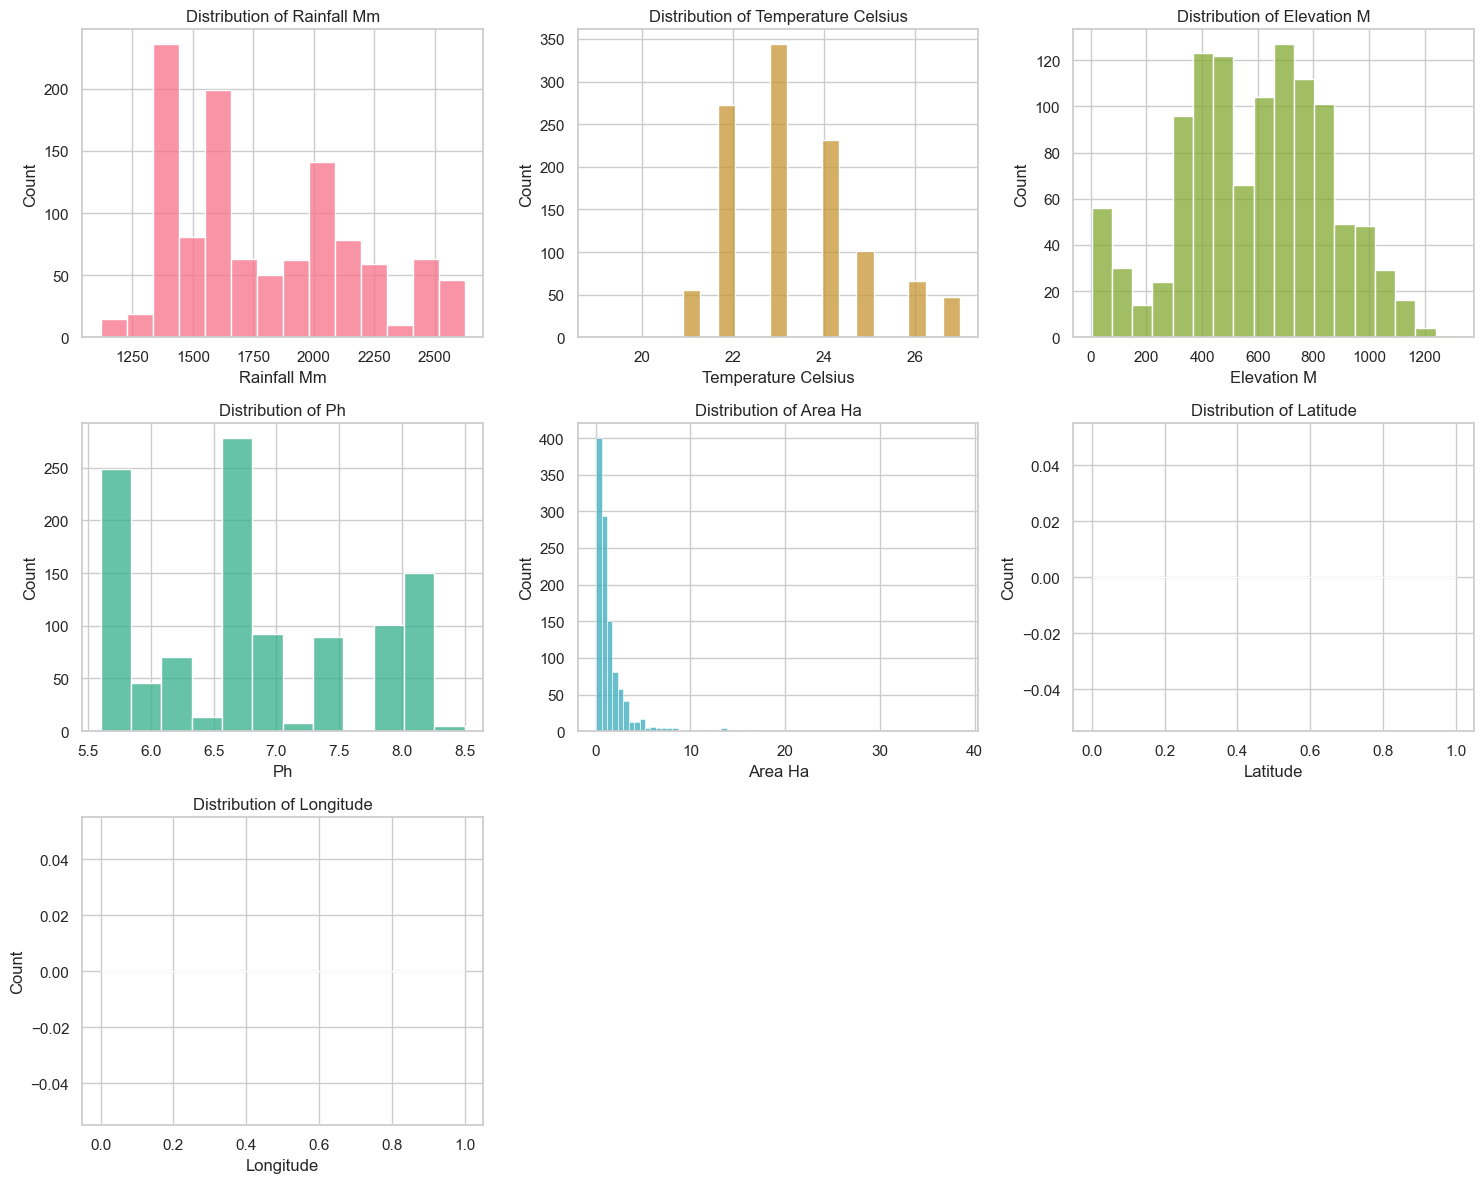

In [57]:
# Plot Numerical Distributions
num_plots = len(farms_numerical_cols)
cols_grid = 3
rows_grid = (num_plots // cols_grid) + (1 if num_plots % cols_grid > 0 else 0)

colors = sns.color_palette("husl", num_plots)

plt.figure(figsize=(15, rows_grid * 4))
for i, col in enumerate(farms_numerical_cols):
    plt.subplot(rows_grid, cols_grid, i + 1)
    sns.histplot(farms_df[col], kde=False, color=colors[i])
    plt.title(f"Distribution of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace("_", " ").title())
    plt.tight_layout()

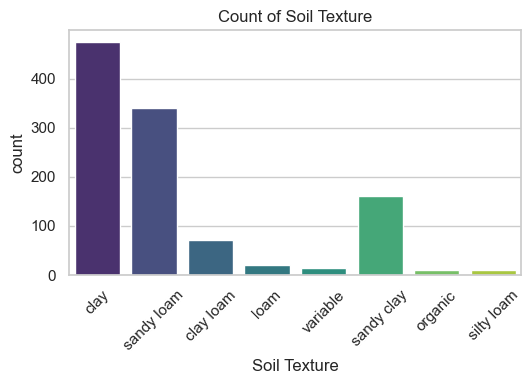

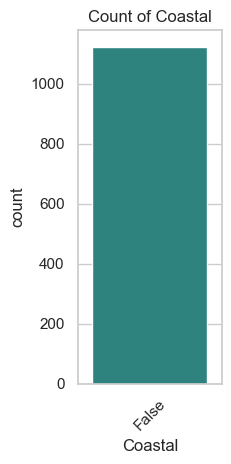

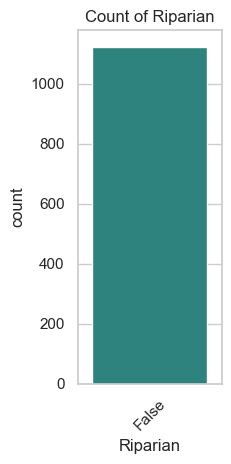

In [58]:
# Plot Categorical Counts
# Check for unique values in categorical columns to avoid overcrowding
valid_farm_cat_cols = [
    col for col in farms_categorical_cols if farms_df[col].nunique() < 20
]

farms_cat_plots = len(valid_farm_cat_cols)
if farms_cat_plots > 0:
    rows_grid_cat = (farms_cat_plots // cols_grid) + (
        1 if farms_cat_plots % cols_grid > 0 else 0
    )

    plt.figure(figsize=(15, rows_grid_cat * 4))
    for i, col in enumerate(valid_farm_cat_cols):
        plt.subplot(rows_grid_cat, cols_grid, i + 1)
        sns.countplot(
            x=farms_df[col], palette="viridis", hue=farms_df[col], legend=False
        )
        plt.title(f"Count of {col.replace('_', ' ').title()}")
        plt.xlabel(col.replace("_", " ").title())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Summary
**Data Structure:**
  * The dataset contains 1122 entries and 11 columns.
  * Columns:
      * Identifiers: `farm_id`
      * Numerical: `rainfall_mm`, `temperature_celsius`, `elevation_m`, `ph`, `area`, `latitude`, `longitude`
      * Characteristics (Categorical/Boolean): `soil_texture`, `costal`, `riparian`

**Data Quality:**
  * `latitude` and `longitude`: These columns are completely empty (all 1122 values are missing), so we cannot map the farms geographically.
  * `soil_texture`: There are 16 missing values.
  *  `ph`: There are 21 farms that have a 0 pH, this is likely an error and has been replaced with the NaN.
  * `coastal` and `riparian` are currently filled with dummy values.
  * All other columns are complete.
  * Data types appear appropriate (integers/floats for ranges, booleans for flags).

**Distributions & Statistics:**
  * Rainfall: Varies between 1119 mm and 2623 mm, with an average of \~1790 mm.
  * Temperature: Relatively consistent, ranging from 19°C to 27°C (avg \~23°C).
  * Elevation: Ranges widely from sea level (3m) up to 1312m.
  * pH: After imputation spans from 5.6 to 8.5. The average is 6.8.
  * Farm Size (`area_ha`): Most farms are small (median 0.88 ha), but there are outliers up to 38.48 ha.

**Visualisations:**
  * Numerical Distributions: The histograms show the spread of rainfall, temperature, elevation, pH, and farm size.
  * Categorical Counts: The bar charts shows the breakdown of soil textures (e.g., clay, sandy loam) and boolean traits like `costal` and `riprian`.

## Clustering

### Pre-processing

In [59]:
# Drop rows with missing soil_texture (16 rows) to ensure data integrity for clustering
farms_clean_df = farms_df.dropna(subset=["soil_texture"]).copy()

In [60]:
# Drop rows with soil_texture of "organic" as it doesn't fit the USDA soil texture classification
farms_clean_df = farms_clean_df[farms_clean_df["soil_texture"] != "organic"]

In [61]:
# Replace "variable" soil texture with "loam"
farms_clean_df.loc[
    farms_clean_df["soil_texture"].str.contains("variable", case=False, na=False),
    "soil_texture",
] = "loam"

In [62]:
# In cells were the pH was 0, replace them with the mean
ph_mean = farms_clean_df["ph"].mean()

# Fill the NaNs with the mean of the column
farms_clean_df["ph"] = farms_clean_df["ph"].fillna(ph_mean)

In [63]:
# Drop any columns that have no values, e.g. latitude and longitude
farms_clean_df.dropna(axis="columns", how="any", inplace=True)
print("\nDataFrame after dropping columns with ANY NaN:")
print(farms_clean_df)


DataFrame after dropping columns with ANY NaN:
      farm_id  rainfall_mm  temperature_celsius  elevation_m   ph  \
0           0         1958                   23          585  6.2   
1           1         1958                   23          481  6.2   
2           2         2020                   25          179  8.2   
3           3         2553                   24          259  5.9   
4           4         2020                   25          129  7.0   
...       ...          ...                  ...          ...  ...   
1117     1127         1209                   26          315  6.7   
1118     1128         1725                   23          700  7.4   
1119     1129         1706                   23          843  7.0   
1120     1130         1706                   23          906  6.2   
1121     1131         1706                   23          915  6.2   

     soil_texture  area_ha  coastal  riparian  
0            clay     0.37    False     False  
1            clay     0.49 

### Encoding

In [64]:
# Categorical/Boolean columns
# Convert booleans to int
farms_boolean_cols = ["coastal", "riparian"]
for col in farms_boolean_cols:
    farms_clean_df[col] = farms_clean_df[col].astype(int)

In [65]:
# One-hot encode soil_texture
# Get dummies and ensure we keep track of them
farms_soil_dummies = pd.get_dummies(farms_clean_df["soil_texture"], prefix="soil")

# Remove lat and long for now until data is available
farms_numerical_cols.remove("latitude")
farms_numerical_cols.remove("longitude")

# Remove costal and riparian for now until data is available
farms_boolean_cols.remove("coastal")
farms_boolean_cols.remove("riparian")

# Combine features
farms_features_df = pd.concat(
    [
        farms_clean_df[farms_numerical_cols],
        farms_clean_df[farms_boolean_cols],
        farms_soil_dummies,
    ],
    axis=1,
)

### Scaling

In [66]:
farms_scaler = StandardScaler()
farms_scaled_features = farms_scaler.fit_transform(farms_features_df)

### k-means clustering

In [67]:
# Determine optimal k
farms_K_range = range(2, 6)
farms_best_k = 2
farms_best_score = -1

for k in farms_K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(farms_scaled_features)
    score = silhouette_score(farms_scaled_features, labels)
    if score > farms_best_score:
        farms_best_score = score
        farms_best_k = k

print(
    f"Optimal number of clusters (k) found: {farms_best_k} (Silhouette Score: {farms_best_score:.3f})"
)

Optimal number of clusters (k) found: 5 (Silhouette Score: 0.438)


In [68]:
# Apply KMeans
farms_kmeans = KMeans(n_clusters=farms_best_k, random_state=42, n_init=10)
farms_clean_df["Cluster"] = farms_kmeans.fit_predict(farms_scaled_features)

In [69]:
# Get the centroids of each cluster
farms_centroids = pd.DataFrame(
    farms_kmeans.cluster_centers_, columns=farms_features_df.columns
)

# Calculate the difference between Clusters
# Get the absolute value difference
farms_diff = farms_centroids.diff().iloc[1].abs()

# Sort to find the most important features
farms_sorted_diff = farms_diff.sort_values(ascending=False)

# Display the results
print("Top features driving the farm cluster separation:")
print(farms_sorted_diff.head(6))

Top features driving the farm cluster separation:
rainfall_mm            1.841757
soil_sandy loam        1.789115
soil_clay              1.637372
elevation_m            1.226060
temperature_celsius    1.131088
area_ha                0.327091
Name: 1, dtype: float64


In [70]:
# Feature for investigation
farms_features_of_interest = [
    "rainfall_mm",
    "elevation_m",
    "temperature_celsius",
]

# Calculate averages per cluster
farms_summary = farms_clean_df.groupby("Cluster")[farms_features_of_interest].mean().T
farms_summary.columns = [
    "Cluster 0",
    "Cluster 1",
    "Cluster 2",
    "Cluster 3",
    "Cluster 4",
]

print("Key Statistics for Farm Classification:")
print(farms_summary)

Key Statistics for Farm Classification:
                       Cluster 0    Cluster 1    Cluster 2    Cluster 3  \
rainfall_mm          1524.950100  2199.024540  1886.604938  1703.816901   
elevation_m           480.690619   800.552147   650.814815   485.225352   
temperature_celsius    24.000000    22.355828    22.950617    24.000000   

                       Cluster 4  
rainfall_mm          1622.694444  
elevation_m           285.027778  
temperature_celsius    24.472222  


In [71]:
# PCA for Visualisation
farms_pca = PCA(n_components=2)
farms_principal_components = farms_pca.fit_transform(farms_scaled_features)
farms_pca_df = pd.DataFrame(data=farms_principal_components, columns=["PC1", "PC2"])
farms_pca_df["Cluster"] = farms_clean_df["Cluster"].values

In [72]:
# Get the correlation between original features and the PCs
farms_loadings = pd.DataFrame(
    farms_pca.components_.T, columns=["PC1", "PC2"], index=farms_features_df.columns
)

# Sort to find the top drivers for each component
farms_top_pc1 = farms_loadings.reindex(
    farms_loadings["PC1"].abs().sort_values(ascending=False).index
).head(10)
farms_top_pc2 = farms_loadings.reindex(
    farms_loadings["PC2"].abs().sort_values(ascending=False).index
).head(10)

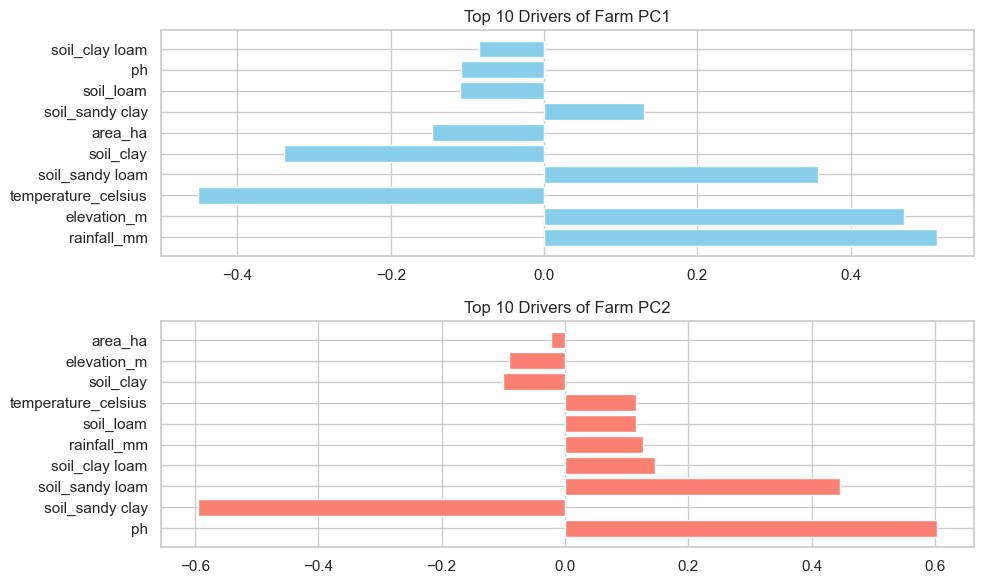

In [73]:
# Plot
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.barh(farms_top_pc1.index, farms_top_pc1["PC1"], color="skyblue")
plt.title("Top 10 Drivers of Farm PC1")

plt.subplot(2, 1, 2)
plt.barh(farms_top_pc2.index, farms_top_pc2["PC2"], color="salmon")
plt.title("Top 10 Drivers of Farm PC2")

plt.tight_layout()

In [74]:
# Analyse Cluster Characteristics
print("\nCluster Averages (Numerical Features):")
print(farms_clean_df.groupby("Cluster")[farms_numerical_cols].mean())

# print("\nCluster Frequencies (Boolean Features):")
# print(farms_clean_df.groupby('Cluster')[farms_boolean_cols].mean())

# Soil Texture Distribution per Cluster
# Group by cluster and then value_counts on the original 'soil_texture' column
print("\nMost Common Soil Texture per Cluster:")
print(
    farms_clean_df.groupby("Cluster")["soil_texture"].agg(
        lambda x: x.value_counts().index[0]
    )
)
print("\nSoil Texture Breakdown per Cluster (Top 3):")
for i in range(farms_best_k):
    print(f"\nCluster {i}:")
    print(
        farms_clean_df[farms_clean_df["Cluster"] == i]["soil_texture"]
        .value_counts()
        .head(3)
    )


Cluster Averages (Numerical Features):
         rainfall_mm  temperature_celsius  elevation_m        ph   area_ha
Cluster                                                                   
0        1524.950100            24.000000   480.690619  6.942715  1.981856
1        2199.024540            22.355828   800.552147  6.975460  1.029755
2        1886.604938            22.950617   650.814815  5.727857  1.483025
3        1703.816901            24.000000   485.225352  7.297183  3.188732
4        1622.694444            24.472222   285.027778  7.264424  1.500000

Most Common Soil Texture per Cluster:
Cluster
0          clay
1    sandy loam
2    sandy clay
3     clay loam
4          loam
Name: soil_texture, dtype: object

Soil Texture Breakdown per Cluster (Top 3):

Cluster 0:
soil_texture
clay          448
sandy loam     43
silty loam     10
Name: count, dtype: int64

Cluster 1:
soil_texture
sandy loam    298
clay           27
silty loam      1
Name: count, dtype: int64

Cluster 2:
soil_te

In [75]:
# Calculate Feature Dominance (Percentage within cluster)
# Cluster 0
cluster_0_data = farms_clean_df[farms_clean_df["Cluster"] == 0]
total_in_cluster_0 = len(cluster_0_data)
clay_farms_in_0 = len(cluster_0_data[cluster_0_data["soil_texture"] == "clay"])

percentage_within_cluster = (clay_farms_in_0 / total_in_cluster_0) * 100
print(f"Percentage of farms with clay soil:{percentage_within_cluster:.1f}%")

# Cluster 1
cluster_1_data = farms_clean_df[farms_clean_df["Cluster"] == 1]
total_in_cluster_1 = len(cluster_1_data)
clay_farms_in_1 = len(cluster_1_data[cluster_1_data["soil_texture"] == "sandy loam"])

percentage_within_cluster = (clay_farms_in_1 / total_in_cluster_1) * 100
print(f"Percentage of farms with sandy loam soil:{percentage_within_cluster:.1f}%")

# Cluster 2
cluster_2_data = farms_clean_df[farms_clean_df["Cluster"] == 2]
total_in_cluster_2 = len(cluster_2_data)
clay_farms_in_2 = len(cluster_2_data[cluster_2_data["soil_texture"] == "sandy clay"])

percentage_within_cluster = (clay_farms_in_2 / total_in_cluster_2) * 100
print(f"Percentage of farms with sandy clay soil:{percentage_within_cluster:.1f}%")

# Cluster 3
cluster_3_data = farms_clean_df[farms_clean_df["Cluster"] == 3]
total_in_cluster_3 = len(cluster_3_data)
clay_farms_in_3 = len(cluster_3_data[cluster_3_data["soil_texture"] == "clay loam"])

percentage_within_cluster = (clay_farms_in_3 / total_in_cluster_3) * 100
print(f"Percentage of farms with clay loam soil:{percentage_within_cluster:.1f}%")

# Cluster 4
cluster_4_data = farms_clean_df[farms_clean_df["Cluster"] == 4]
total_in_cluster_4 = len(cluster_4_data)
clay_farms_in_4 = len(cluster_4_data[cluster_4_data["soil_texture"] == "loam"])

percentage_within_cluster = (clay_farms_in_4 / total_in_cluster_4) * 100
print(f"Percentage of farms with loam soil:{percentage_within_cluster:.1f}%")

Percentage of farms with clay soil:89.4%
Percentage of farms with sandy loam soil:91.4%
Percentage of farms with sandy clay soil:100.0%
Percentage of farms with clay loam soil:100.0%
Percentage of farms with loam soil:100.0%



Five distinct clusters of farms have been identified. The farms are primarily grouped by Soil Texture and Elevation/Rainfall.

### Cluster Profiles

Here is a breakdown of the five farm types:

* Cluster 0: "Lowland clay farms" (largest group)

  * Dominant Feature: Clay soil (89% of farms).
  * Environment: Lower elevation (\~475m) and lower rainfall (\~1526mm).
  * Size: Average farm size is \~1.98 ha.

* Cluster 1: "Highland sandy loam farms"

  * Dominant Feature: Sandy loam soil (91% of farms).
  * Environment: Highest elevation (\~802m) and highest rainfall (\~2201mm). These are likely hill farms.
  * Size: Smaller farms (\~1.02 ha).

* Cluster 2: "Acidic sandy clay farms"

  * Dominant Feature: Sandy clay soil 100% match).
  * Environment: Moderate elevation (\~650m).
  * Key Trait: Significantly more acidic soil (pH 5.7) compared to the others (pH \~7.0).

* Cluster 3: "Large clay loam farms"

  * Dominant Feature: Clay loam soil (100% match).
  * Environment: Moderate rainfall (\~1704mm).
  * Size: Largest farms in the dataset (avg \~3.19 ha).

* Cluster 4: "Coastal Farms" (Smallest group)

  * Dominant Feature: Loam soil (100% match).
  * Environment: Lowest elevation (\~87m) and highest temperature (\~26°C), suggesting coastal or low-lying areas.
  * Size: Average size \~1.5 ha.

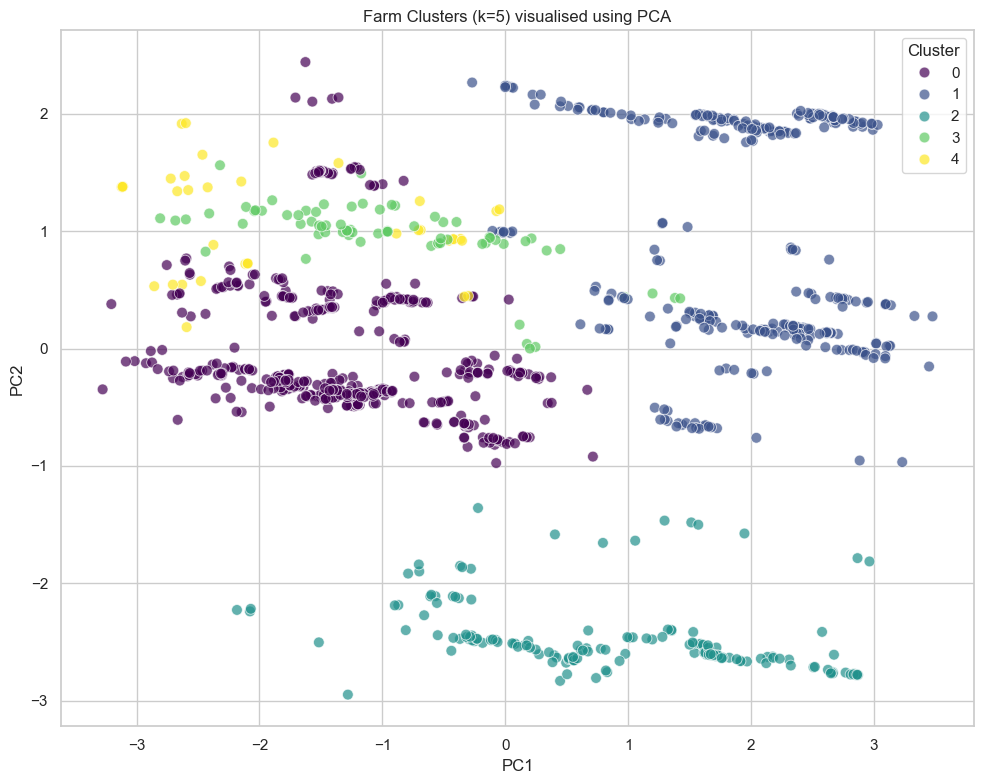

In [76]:
# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Cluster",
    data=farms_pca_df,
    palette="viridis",
    s=60,
    alpha=0.7,
)
plt.title(f"Farm Clusters (k={farms_best_k}) visualised using PCA")
plt.tight_layout()

#### Principal components

PC1 captures the primary geographical and soil divide in the farms.

  * Positive Side (+): Driven by temperature and clay Soil. Farms on this side are warmer and have clay soil.
  * Negative Side (-): Strongly driven by rainfall and elevation. Farms on this side are high-altitude, high-rainfall sites.

PC2 captures a specific soil chemistry pattern.

  * Positive Side (-): Driven by pH (acidity/alkalinity) and sandy loam.
      * Since pH has a negative loading, a lower value on this axis means higher pH (more alkaline), and a higher value (positive side) means lower pH (more acidic).
      * This confirms why Cluster 3 (Acidic sandy clay) likely sits high on the PC2 axis: it has the positive trait (sandy clay) and the negative trait (Low pH) working together.
  * Negative Side (+): Dominated by sandy clay soil.


#### Scatter plot summary

  * Moving Right (PC1 \> 0): Farms that are low, warm and clay soils.
  * Moving Left (PC1 \< 0): Farms that are high, wet and sandy soils.
  * Moving Up (PC2 \> 0): Farms that have neutral/alkaline sandy loam soils.
  * Moving Down (PC2 \< 0): Farms that have acidic sandy clay.

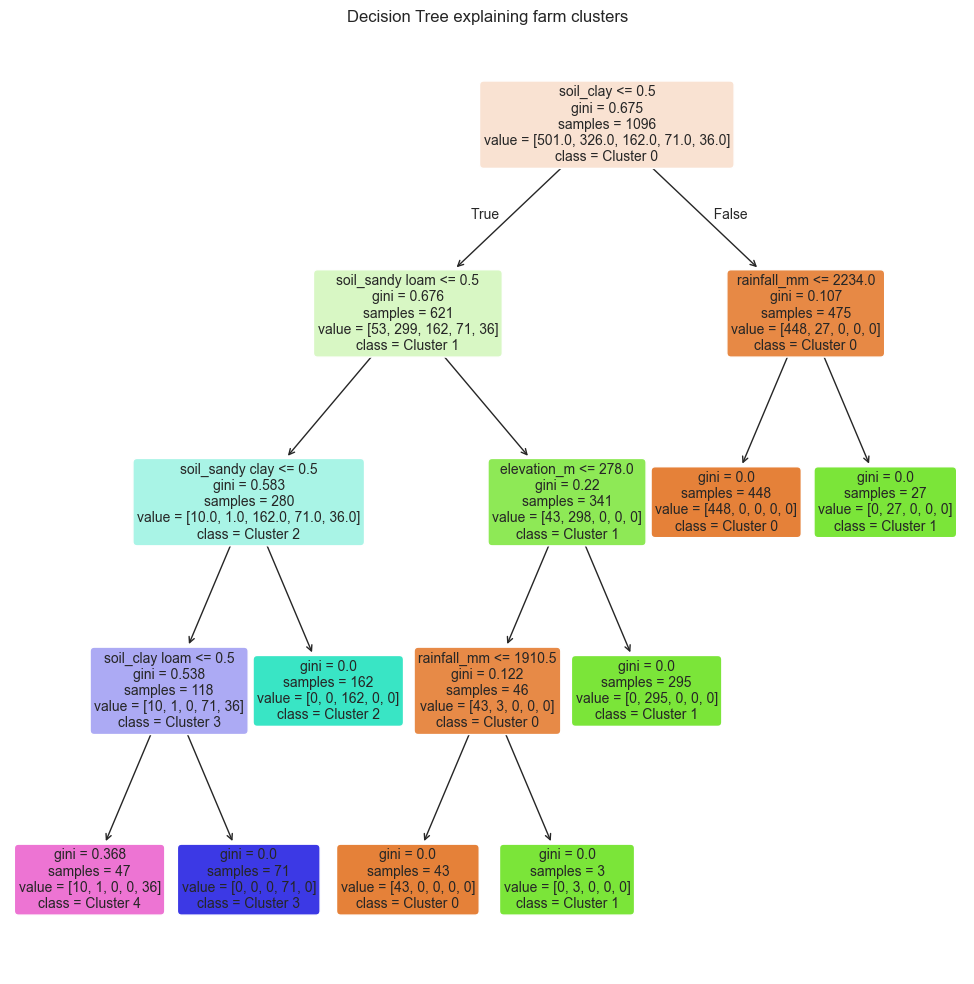

In [77]:
# Train Decision Tree
farm_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
farm_clf.fit(farms_features_df, farms_clean_df["Cluster"])

# Plot the tree
plt.figure(figsize=(10, 10))
plot_tree(
    farm_clf,
    feature_names=farms_features_df.columns,
    class_names=[f"Cluster {i}" for i in range(5)],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Decision Tree explaining farm clusters")
plt.tight_layout()


### Decision Tree analysis

The tree structure confirms that rainfall and soil texture are the primary decision-makers, with elevation playing a role in separating high-rainfall areas.

The rules (Simplified):

Is it clay soil?

  * Yes: It checks rainfall.
    * \<= 2234mm: Assigned to Cluster 0 (Lowland clay). This covers the vast majority of clay farms.
    * \> 2234mm: Assigned to Cluster 1. (Very wet clay farms get grouped with the "Highland" cluster).

  * No (not clay): It checks if it is sandy loam.
    * Yes (sandy loam): It checks elevation.
        * \> 278m: Assigned to Cluster 1 (Highland sandy loam). This is the core of the "Highland" group.
        * \<= 278m: It checks rainfall.
            * High rain: Cluster 1.
            * Low rain: Cluster 0.
    * No (not sandy loam either): It looks for the specific minority soils.
      * Sandy clay? -\> Cluster 2 (Acidic sandy clay).
      * Clay loam? -\> Cluster 3 (Large clay loam).
      * Loam? -\> Cluster 4.

# Creating a cleaned dataset

In [78]:
# Re-load the dataset
df = pd.read_excel("../../data/farms.xlsx")

# Perform data clean steps identified in EDA

# Convert the 'soil_texture' column to lowercase
df["soil_texture"] = df["soil_texture"].str.lower()

# Replace "variable" with "loam" to match the possible soil categories
df["soil_texture"] = df["soil_texture"].replace("variable", "loam")

# Replace "organic" with None to allow prediction as it doesn't fit the USDA soil texture classification
df["soil_texture"] = df["soil_texture"].replace("organic", None)

# Fix pH: Replace 0 values with the mean of non-zero values
# Convert ph==0 to NaN (so pandas ignores them)
df["ph"] = df["ph"].replace(0, np.nan)
ph_mean = df["ph"].mean()
df["ph"] = df["ph"].fillna(ph_mean)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
farm_id                   0
rainfall_mm               0
temperature_celsius       0
elevation_m               0
ph                        0
soil_texture             26
area_ha                   0
latitude               1122
longitude              1122
coastal                   0
riparian                  0
dtype: int64


In [79]:
# Split the data into two sets
# Set A: Farms where the soil type is known (Training Data)
df_known = df.dropna(subset=["soil_texture"]).copy()

# Set B: Farms where the soil type is missing (Prediction Targets)
df_unknown = df[df["soil_texture"].isnull()].copy()

print(f"Training on {len(df_known)} farms.")
print(f"Predicting for {len(df_unknown)} farms.")

Training on 1096 farms.
Predicting for 26 farms.


In [80]:
# Define the features to use for prediction
# Use environmental factors
feature_cols = ["rainfall_mm", "temperature_celsius", "elevation_m", "ph"]

X_train = df_known[feature_cols]
y_train = df_known["soil_texture"]
X_predict = df_unknown[feature_cols]

In [81]:
# Cross validation
clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate Scores
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Minimum Accuracy: {scores.min() * 100:.2f}%")
print(f"Maximum Accuracy: {scores.max() * 100:.2f}%")
print(f"Mean Accuracy: {scores.mean() * 100:.2f}%")

Minimum Accuracy: 95.45%
Maximum Accuracy: 98.18%
Mean Accuracy: 96.72%


<Axes: >

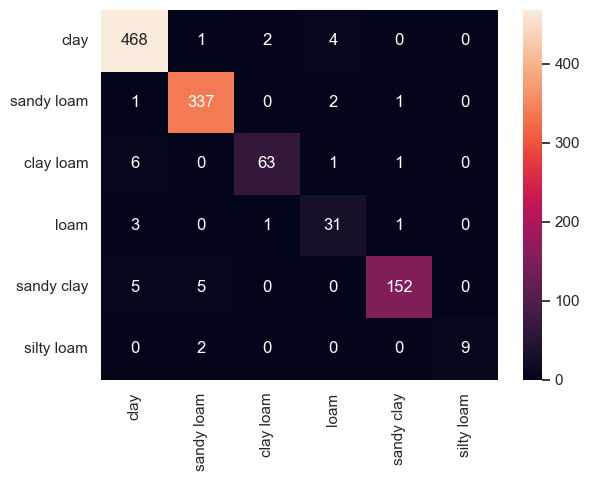

In [82]:
# Plot Confusion Matrix
y_pred = cross_val_predict(clf, X_train, y_train, cv=cv)
cm = confusion_matrix(y_train, y_pred, labels=y_train.unique())
sns.heatmap(
    cm, annot=True, fmt="d", xticklabels=y_train.unique(), yticklabels=y_train.unique()
)

Accuracy Results:

  * Mean Accuracy: 96.7%
  * The model is extremely consistent, with individual fold scores ranging from 95.5% to 98.2%. This confirms that the model is robust and not just over-fitting to a specific subset of the data.

Confusion Matrix Analysis:
  * Diagonal Values: These represent correct predictions. The model gets most soil types right.
  * Off-Diagonal Values: These are the errors.
      * For example, looking at the row for clay, there are a few instances misclassified as sandy loam, clay loam and loam.

In [83]:
final_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on all data
final_clf.fit(X_train, y_train)

# Make predictions of soil type
predicted_soils = final_clf.predict(X_predict)

In [84]:
# Display Results
results = df_unknown[["farm_id", "rainfall_mm", "elevation_m"]].copy()
results["Predicted_Soil_Texture"] = predicted_soils

print("\nPredictions for missing farms:")
print(results)


Predictions for missing farms:
     farm_id  rainfall_mm  elevation_m Predicted_Soil_Texture
15        15         1821           78                   clay
38        38         1580           32                   clay
39        39         1580           18                   loam
41        41         1580           25                   loam
43        43         1580           23                   loam
49        49         1580           16                   loam
66        66         1580           18                   loam
114      114         1580           17                   loam
144      144         2366          289             sandy clay
221      221         1357          357                   clay
222      222         1357          354                   clay
223      223         1357          349                   clay
225      225         1357          355                   clay
260      260         1357          350                   clay
263      263         1357          353

In [85]:
# Predict the soil texture
df_unknown["soil_texture"] = final_clf.predict(df_unknown[feature_cols])

# Re-combine datasets PCA/Clustering
df_full = pd.concat([df_known, df_unknown])

# Mark which farms were predicted for plotting later
df_full["is_predicted"] = df_full.index.isin(df_unknown.index)

# Update soil One-Hot Encoding
soil_dummies = pd.get_dummies(df_full["soil_texture"], prefix="soil")
features = pd.concat([df_full[farms_numerical_cols], soil_dummies], axis=1)

In [86]:
# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [87]:
# Clustering (Re-create the 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_full["Cluster"] = kmeans.fit_predict(scaled_features)

In [88]:
# PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(scaled_features)

df_full["PC1"] = coords[:, 0]
df_full["PC2"] = coords[:, 1]

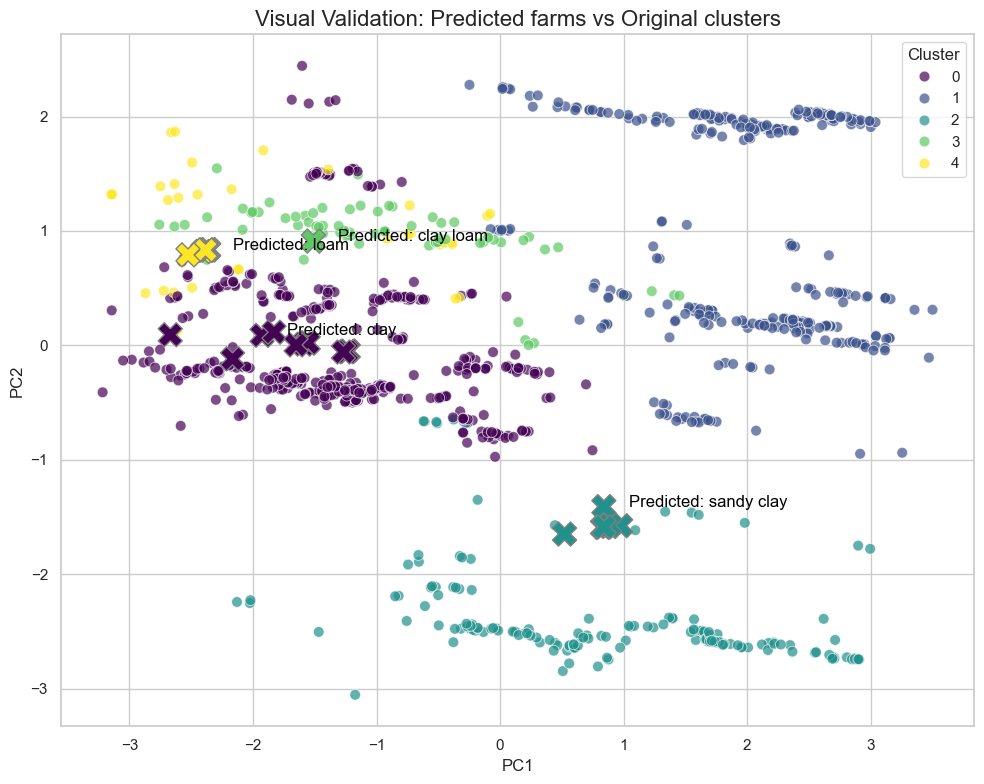

In [89]:
# Cluster number is not guaranteed to be consistent
# I'm going to find the mapping from the new cluster numbering to the old

# The reference numbering from earlier
df_ref = farms_pca_df

# New prediction but only for the known soil texture
original_data = df_full[~df_full["is_predicted"]].copy()

# Create a Confusion Matrix (Intersection of farms)
# Rows = New Clusters, Cols = Ref Clusters
cm = confusion_matrix(original_data["Cluster"], df_ref["Cluster"])

# Find the Best 1-to-1 Mapping
# This finds the combination that maximizes the total overlap
rows, cols = linear_sum_assignment(cm, maximize=True)
mapping = dict(zip(rows, cols))

# Apply the Mapping
original_data["Cluster"] = original_data["Cluster"].map(mapping)

# Plot with the corrected labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=original_data,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    s=60,
    alpha=0.7,
)
# plt.title(f"Farm Clusters (k={farms_best_k}) visualised using PCA")

# Plot Predicted Data (prominent)
predicted_data = df_full[df_full["is_predicted"]].copy()

# Apply the Mapping
predicted_data["Cluster"] = predicted_data["Cluster"].map(mapping)

# Predicted data plotted with an X
sns.scatterplot(
    data=predicted_data,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    s=300,
    marker="X",
    edgecolor="grey",
    linewidth=1,
    legend=False,
)

# Add annotations for a few predicted points to confirm logic
# Label a clay prediction
clay_pred = predicted_data[predicted_data["soil_texture"] == "clay"]
if not clay_pred.empty:
    x, y = clay_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: clay", fontsize=12, color="black")

# Label a sandy clay prediction
sandy_clay_pred = predicted_data[predicted_data["soil_texture"] == "sandy clay"].head(1)
if not sandy_clay_pred.empty:
    x, y = sandy_clay_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: sandy clay", fontsize=12, color="black")

# Label a clay loam prediction
clay_loam_pred = predicted_data[predicted_data["soil_texture"] == "clay loam"].head(1)
if not clay_loam_pred.empty:
    x, y = clay_loam_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: clay loam", fontsize=12, color="black")

# Label a loam prediction
loam_pred = predicted_data[predicted_data["soil_texture"] == "loam"].head(1)
if not loam_pred.empty:
    x, y = loam_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: loam", fontsize=12, color="black")

plt.title("Visual Validation: Predicted farms vs Original clusters", fontsize=16)

plt.tight_layout()
plt.show()

In [90]:
# Columns not needed in export
columns_to_drop = ["Cluster", "PC1", "PC2"]

# Drop columns
df_export = df_full.drop(columns=columns_to_drop)

# Export to Excel
# index=False prevents the row numbers from being saved as a column
df_export.to_excel("../../data/farms_cleaned.xlsx", index=False)